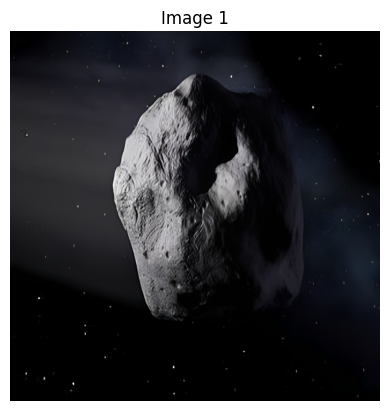

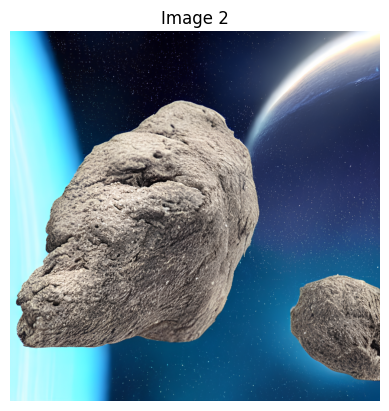

In [13]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

directory = os.listdir('/kaggle/input/spacenet-an-optimally-distributed-astronomy-data/SpaceNet.FLARE.imam_alam/asteroid')
main_folder = '/kaggle/input/spacenet-an-optimally-distributed-astronomy-data/SpaceNet.FLARE.imam_alam/asteroid'

files = os.listdir(main_folder)[:2]

for i, file in enumerate(files):
    fullpath = os.path.join(main_folder, file)
    img = mpimg.imread(fullpath)
    
    plt.figure()  # Create a new figure for each image
    plt.imshow(img)
    plt.title(f"Image {i+1}")  
    plt.axis('off') 
    plt.show()  # Display the image


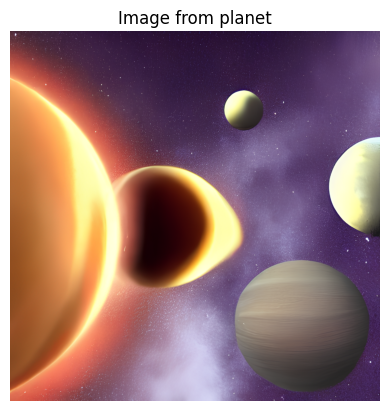

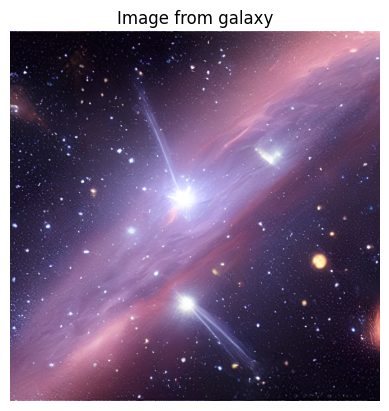

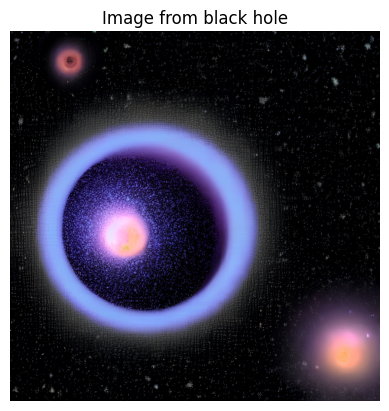

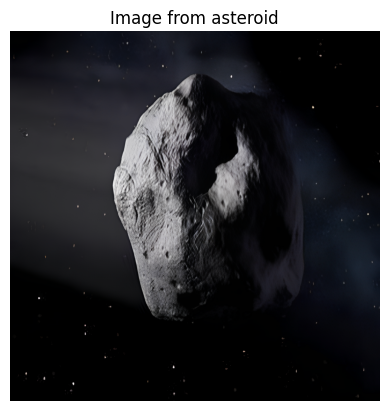

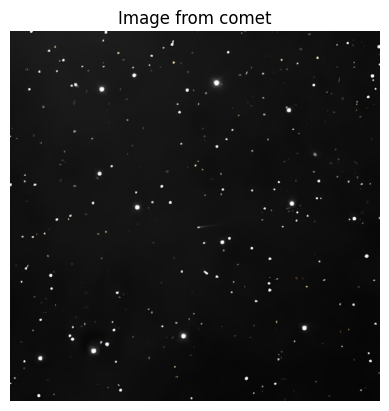

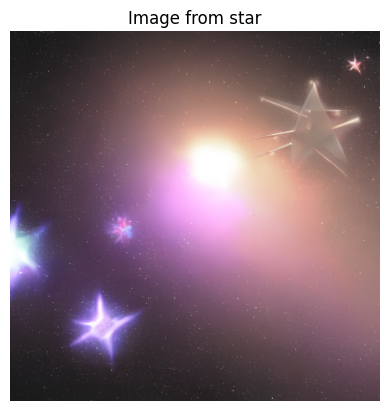

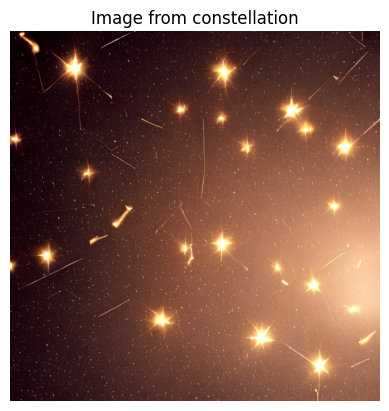

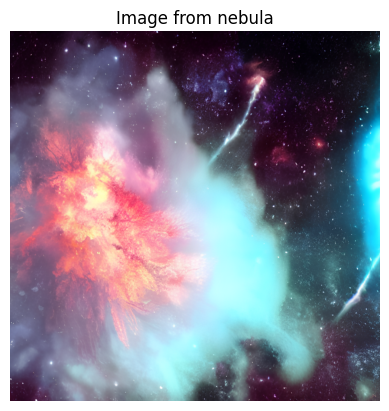

In [14]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

main_folder = '/kaggle/input/spacenet-an-optimally-distributed-astronomy-data/SpaceNet.FLARE.imam_alam'

subdirectories = os.listdir(main_folder)

for subdir in subdirectories:
    subdir_path = os.path.join(main_folder, subdir)
    
    if os.path.isdir(subdir_path):
        image_files = os.listdir(subdir_path)
        
        if image_files:
            first_image = image_files[0]
            full_image_path = os.path.join(subdir_path, first_image)
            
            img = mpimg.imread(full_image_path)
            
            plt.figure()  
            plt.imshow(img)
            plt.title(f"Image from {subdir}")  # Title indicating the directory
            plt.axis('off')  
            plt.show()  


In [8]:
import numpy as np
import tensorflow as tf
import pandas as pd
import os 
import seaborn 
import keras

In [10]:
from tensorflow.keras import layers, Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dropout, Dense, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import LabelEncoder
import matplotlib.image as mpimg
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
import random
import warnings 
warnings.filterwarnings('ignore')

In [12]:
#image size et batch size
image_size = (224, 224)
batch_size = 32 

In [6]:
import os
import shutil

# Chemin vers le nouveau dossier à créer
dossier_astronomy = '/kaggle/working/dossier_astronomy'

# Créer le nouveau dossier s'il n'existe pas
os.makedirs(dossier_astronomy, exist_ok=True)

# Chemins vers les dossiers d'origine
dossiers = [
    '/kaggle/input/spacenet-an-optimally-distributed-astronomy-data/SpaceNet.FLARE.imam_alam/asteroid',
    '/kaggle/input/spacenet-an-optimally-distributed-astronomy-data/SpaceNet.FLARE.imam_alam/black hole',
    '/kaggle/input/spacenet-an-optimally-distributed-astronomy-data/SpaceNet.FLARE.imam_alam/nebula',
    '/kaggle/input/spacenet-an-optimally-distributed-astronomy-data/SpaceNet.FLARE.imam_alam/planet',
]

# Déplacer chaque dossier dans le nouveau dossier
for dossier in dossiers:
    # Copier ou déplacer les dossiers vers le nouveau répertoire
    destination = os.path.join(dossier_astronomy, os.path.basename(dossier))
    shutil.copytree(dossier, destination)  # Utilise shutil.move pour déplacer au lieu de copier

print("Tous les dossiers ont été combinés dans 'astronomy_dossier'.")


Tous les dossiers ont été combinés dans 'astronomy_dossier'.


In [13]:
from pandas.io.formats.style_render import Subset
#training data 
train_data = tf.keras.preprocessing.image_dataset_from_directory(
    dossier_astronomy,
    subset = 'training',
    validation_split = 0.2,
    image_size = image_size,
    batch_size = batch_size,
    seed = 42
)

Found 3603 files belonging to 4 classes.
Using 2883 files for training.


In [14]:
#testing data 
test_data = tf.keras.preprocessing.image_dataset_from_directory(
    dossier_astronomy,
    subset = 'validation',
    validation_split = 0.2,
    image_size = image_size,
    batch_size = batch_size,
    seed = 42
)

Found 3603 files belonging to 4 classes.
Using 720 files for validation.


In [15]:
class_names = train_data.class_names
class_names

['asteroid', 'black hole', 'nebula', 'planet']

In [16]:
#encoder les classes names pour les rendre des chiffres
label_encoder = LabelEncoder()
class_names_label_encoder = label_encoder.fit_transform(class_names)
class_names_label_encoder

array([0, 1, 2, 3])

In [17]:
#image processing 
def preprocess_image(image, label, image_shape=224):
  img = tf.image.resize(image, [image_shape, image_shape])
  img = img/225
  return tf.cast(img, tf.float32), label
     

In [19]:
#map the preprocess_image to train_data
train_data = train_data.map(map_func = preprocess_image, num_parallel_calls= tf.data.AUTOTUNE)

#shuffle the data
train_data = train_data.shuffle(buffer_size= 1000).prefetch(buffer_size = tf.data.AUTOTUNE)

#map the preprocess_image to valid data
test_data = test_data.map(map_func = preprocess_image, num_parallel_calls= tf.data.AUTOTUNE)
#shuffle the data
test_data = test_data.shuffle(buffer_size= 1000).prefetch(buffer_size = tf.data.AUTOTUNE)
     

In [20]:
train_data_size = tf.data.experimental.cardinality(train_data).numpy()
test_data_size = tf.data.experimental.cardinality(test_data).numpy()

print(f"Training data size: {train_data_size}")
print(f"Test data size: {test_data_size}")


Training data size: 91
Test data size: 23


In [21]:
train_data, test_data


(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>)

In [22]:
tf.random.set_seed(42)


In [23]:
#model 1 
model_1 = Sequential(
    [
        Conv2D(filters= 32, kernel_size = 4, padding = 'same', activation = 'relu', input_shape = (224, 224, 3)),
        MaxPool2D(2,2),
        Conv2D(filters= 64, kernel_size = 4, padding = 'same', activation = 'relu', input_shape = (224, 224, 3)),
        MaxPool2D(2,2),
        Conv2D(filters= 64, kernel_size = 4, padding = 'same', activation = 'relu', input_shape = (224, 224, 3)),
        MaxPool2D(2,2),
        Dropout(0.5), #reduire l'overfitting lors de l'entrainement du model (desactiver temporairement certains neurones dans le reseau + toutes ses connexions, le choix de ces neurones est aleatoire)
        Flatten(),
        Dense(len(class_names_label_encoder), activation = 'softmax')
     
    ]
)

In [24]:
#compile

model_1.compile(loss = tf.keras.losses.SparseCategoricalCrossentropy(),
                optimizer = 'adam',
                metrics=['accuracy'])

#fitting
#model_1.fit(train_data, epochs = 5, validation_data = test_data)

Epoch 1/5
91/91 ━━━━━━━━━━━━━━━━━━━━ 394s 3s/step - accuracy: 0.3869 - loss: 1.2889 - val_accuracy: 0.4292 - val_loss: 1.2246
Epoch 2/5
91/91 ━━━━━━━━━━━━━━━━━━━━ 404s 3s/step - accuracy: 0.4153 - loss: 1.2563 - val_accuracy: 0.4292 - val_loss: 1.2164
Epoch 3/5
91/91 ━━━━━━━━━━━━━━━━━━━━ 448s 3s/step - accuracy: 0.3857 - loss: 1.2496 - val_accuracy: 0.4292 - val_loss: 1.2199
Epoch 4/5
91/91 ━━━━━━━━━━━━━━━━━━━━ 395s 3s/step - accuracy: 0.4235 - loss: 1.2332 - val_accuracy: 0.4708 - val_loss: 1.1444
Epoch 5/5
91/91 ━━━━━━━━━━━━━━━━━━━━ 425s 3s/step - accuracy: 0.4580 - loss: 1.1886 - val_accuracy: 0.5014 - val_loss: 1.1386


In [26]:
#transfer learning
# Download Inception V3 model
base_model_inception = tf.keras.applications.inception_v3.InceptionV3(include_top=False)

# Freeze the layers
base_model_inception.trainable=False

# Inputs
inputs = tf.keras.layers.Input(shape=(224,224,3), name='input_layer')

# Scaling the values
x = tf.keras.layers.Rescaling(1./255)(inputs)

# Pass inputs to our base_model
x = base_model_inception(inputs,training=False)

# GlobalAveragePooling2D
x = tf.keras.layers.GlobalAveragePooling2D()(x)

# outputs
outputs = tf.keras.layers.Dense(len(class_names_label_encoder), activation='softmax')(x)

# Build model
model_4 = tf.keras.Model(inputs, outputs)

# Compile the model
model_4.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
               optimizer='adam',
               metrics=['accuracy'])

In [27]:
# Fit the model
history_4 = model_4.fit(train_data,
                       epochs=30,
                       validation_data=test_data)

Epoch 1/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 424s 3s/step - accuracy: 0.4281 - loss: 1.2529 - val_accuracy: 0.5583 - val_loss: 1.1245
Epoch 2/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 463s 3s/step - accuracy: 0.6206 - loss: 1.0908 - val_accuracy: 0.6611 - val_loss: 0.9912
Epoch 3/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 366s 3s/step - accuracy: 0.6627 - loss: 0.9899 - val_accuracy: 0.6569 - val_loss: 0.9477
Epoch 4/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 378s 3s/step - accuracy: 0.6448 - loss: 0.9681 - val_accuracy: 0.6694 - val_loss: 0.9040
Epoch 5/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 359s 3s/step - accuracy: 0.6582 - loss: 0.9333 - val_accuracy: 0.6750 - val_loss: 0.8903
Epoch 6/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 379s 3s/step - accuracy: 0.6821 - loss: 0.8906 - val_accuracy: 0.6736 - val_loss: 0.8415
Epoch 7/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 357s 3s/step - accuracy: 0.6883 - loss: 0.8590 - val_accuracy: 0.7069 - val_loss: 0.8263
Epoch 8/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 357s 3s/step - accuracy: 0.7214 - loss: 0.8226 - val_accuracy: 0.7236 - v